# Real vs Synthetic Images

In this notebook we compare synthetic and ground truth images for the 4 channels in a quiet day and in correspondence of a flare

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from typing import Dict
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from torch.utils.data import DataLoader
import torch

from sunpy.visualization.colormaps import cm

from sdo.datasets.sdo_dataset import SDO_Dataset
from sdo.datasets.virtual_telescope_sdo_dataset import VirtualTelescopeSDO_Dataset
from sdo.models.vt_models.vt_unet import VT_UnetGenerator

In [2]:
def compute_predictions(timestamp :str , ch_dict, model_key) -> Dict:
    datetime = [[timestamp, timestamp]]
    results_dict = {}
    root_scaling = False
    if model_key == "model_root":
        root_scaling = 2

    for ch in ["211", "193", "171", "094"]:
        print(f"-----{ch}------")
        # Load input data - we reload the data each time for convenience, the first 3 channels are
        # assumed to be the inputs and packed in a single tensor
        data = VirtualTelescopeSDO_Dataset(data_basedir='/fdl_sdo_data/SDOMLmm/fdl_sw/SDOMLmm', 
            data_inventory='/fdl_sdo_data/bucket/inventory_1904.pkl', 
            instr=["AIA", "AIA", "AIA", "AIA"],
            num_channels = 4,
            channels=ch_dict[ch]["channels"],
            datetime_range = datetime,
            resolution=512,
            subsample=1,
            scaling=True,
            root_scaling = root_scaling
            )

        if len(data) < 1:
            print("Date not found")

        # Load model - each channel combination has a model with different weights
        model_path = results_path + ch_dict[ch][model_key]
        model = VT_UnetGenerator(input_shape=[3, 512, 512])
        state_dict = torch.load(model_path)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k.replace("module.", "") 
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict, strict=False)
        model.eval();

        # Compute prediction
        input_chs = data[0][0].unsqueeze(0)
        output = model(input_chs).detach().numpy().reshape(512, 512)
        gt_img = data[0][1].detach().numpy().reshape(512, 512)

        results_dict[ch] =  {"gt": gt_img, "pred": output, "input": input_chs}
    return results_dict

In [17]:
def plot_4ch_grid(results_dict: Dict, ch_dict: Dict) -> plt.Figure:
    fig, ax = plt.subplots(4, 3, figsize=(11.5,15))
    fig.subplots_adjust(wspace=0.01, hspace=0.055)
    i = 0
    for ch in ["211", "193", "171", "094"]:
        gt_img = results_dict[ch]["gt"]
        pred = results_dict[ch]["pred"]
        cmap = ch_dict[ch]["cmap"]
        if ch in ["211", "171"]:
            vmin1 = vmin2 = 0
            vmax1 = vmax2 = 3
            vmin3 = -0.8
            vmax3= 0.8
        elif ch == "193":
            vmin1 = vmin2 = 0
            vmax1 = vmax2 = 2
            vmin3 = -0.8
            vmax3= 0.8
        elif ch == "094":
            vmin1 = vmin2 = 0
            vmax1 = vmax2= 100
            # vmax2 = 0.5
            vmin3 = -0.8
            vmax3= 0.8
        ax[i, 0].imshow(gt_img, cmap=cmap, origin='lower', vmin=vmin1, vmax= vmax1)
        ax[i, 1].imshow(pred, cmap=cmap, origin='lower', vmin=vmin2, vmax= vmax2)
        ax[i, 0].set_ylabel(f'{ch} $\AA$')
        ax[0, 0].set_title('Ground Truth')
        ax[0, 1].set_title('Prediction')
        ax[0, 2].set_title('Pred - GT')
        im = ax[i, 2].imshow(pred - gt_img, cmap='seismic', origin='lower', vmin=vmin3, vmax=vmax3)
        divider = make_axes_locatable(ax[i, 2])
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        i = i + 1
    plt.setp(ax, xticks=[], yticks=[])
    plt.show()
    return fig

In [4]:
results_path = '/fdl_sdo_data/bucket/EXPERIMENT_RESULTS/VIRTUAL_TELESCOPE/'
output_path = "../../results/plots/"

ch_dict = {"211": {"model_nr": 'vale_exp_20/0600_vale_exp_20_model.pth',
                    "model_root": 'vale_exp_23/0600_vale_exp_23_model.pth',
                    "channels": ["0094", "0193", "0171", "0211"],
                    "cmap": cm.cmlist.get("sdoaia211"),
                   }
            ,
            "193": {"model_nr": '/vale_exp_13bis/0600_vale_exp_13bis_model.pth',
                    "model_root": 'vale_exp_25/0600_vale_exp_25_model.pth',
                    "channels": ["0094", "0211", "0171", "0193"],
                    "cmap": cm.cmlist.get("sdoaia193"),
                   }
            ,
            "171": {"model_nr": '/vale_exp_14bis/0600_vale_exp_14bis_model.pth',
                    "model_root": 'vale_exp_26/0600_vale_exp_26_model.pth',
                    "channels": ["0094", "0193", "0211", "0171"],
                    "cmap": cm.cmlist.get("sdoaia171")
                   }
            ,
            "094": {"model_nr": '/vale_exp_18/0600_vale_exp_18_model.pth',
                    "model_root": 'vale_exp_27/0400_vale_exp_27_model.pth',
                    "channels": ["0211", "0171", "0193", "0094"],
                    "cmap": cm.cmlist.get("sdoaia94")}
           }

ch_dict_root = {"211": {"model_nr": 'vale_exp_20/0600_vale_exp_20_model.pth',
                      "model_root": 'vale_exp_23/0600_vale_exp_23_model.pth',
                      "channels": ["0094", "0193", "0171", "0211"],
                      "cmap": cm.cmlist.get("sdoaia211"),
                     }
                ,
                "193": {"model_nr": '/vale_exp_13bis/0600_vale_exp_13bis_model.pth',
                        "model_root": 'vale_exp_25/0600_vale_exp_25_model.pth',
                        "channels": ["0171", "0211", "0094", "0193"],
                        "cmap": cm.cmlist.get("sdoaia193"),
                       }
                ,
                "171": {"model_nr": '/vale_exp_14bis/0600_vale_exp_14bis_model.pth',
                        "model_root": 'vale_exp_26/0600_vale_exp_26_model.pth',
                        "channels": ["0211", "0094", "0193", "0171"],
                        "cmap": cm.cmlist.get("sdoaia171")
                       }
                ,
                "094": {"model_nr": '/vale_exp_18/0600_vale_exp_18_model.pth',
                        "model_root": 'vale_exp_27/0400_vale_exp_27_model.pth',
                        "channels": ["0193", "0171", "0211", "0094"],
                        "cmap": cm.cmlist.get("sdoaia94")}
               }

## Images on quiet Sun

In [5]:
quiet_day = '2011-01-14 00:00:00'

### Compute predictions

In [6]:
nr_results_dict = compute_predictions(quiet_day, ch_dict, "model_nr")

-----211------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----193------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----171------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----094------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [7]:
root_results_dict = compute_predictions(quiet_day, ch_dict_root, "model_root")

-----211------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----193------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----171------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----094------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [8]:
np.max(nr_results_dict["094"]['pred'])

0.074533686

In [9]:
np.max(nr_results_dict["094"]['gt'])

404.10254

### Plot images

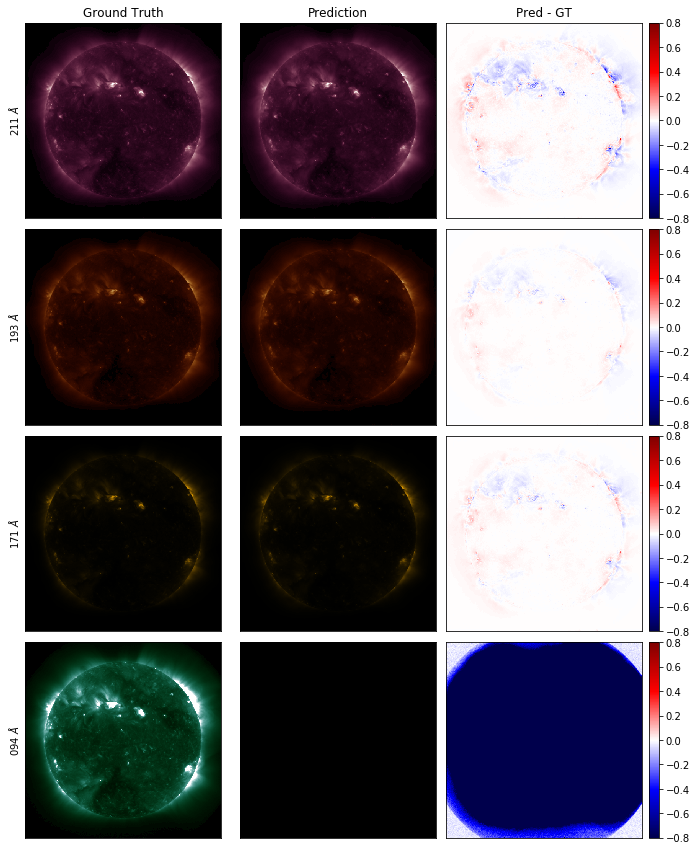

In [29]:
fig = plot_4ch_grid(nr_results_dict, ch_dict)
filename = output_path + "real_vs_pred_quiet_nr.png"
fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)

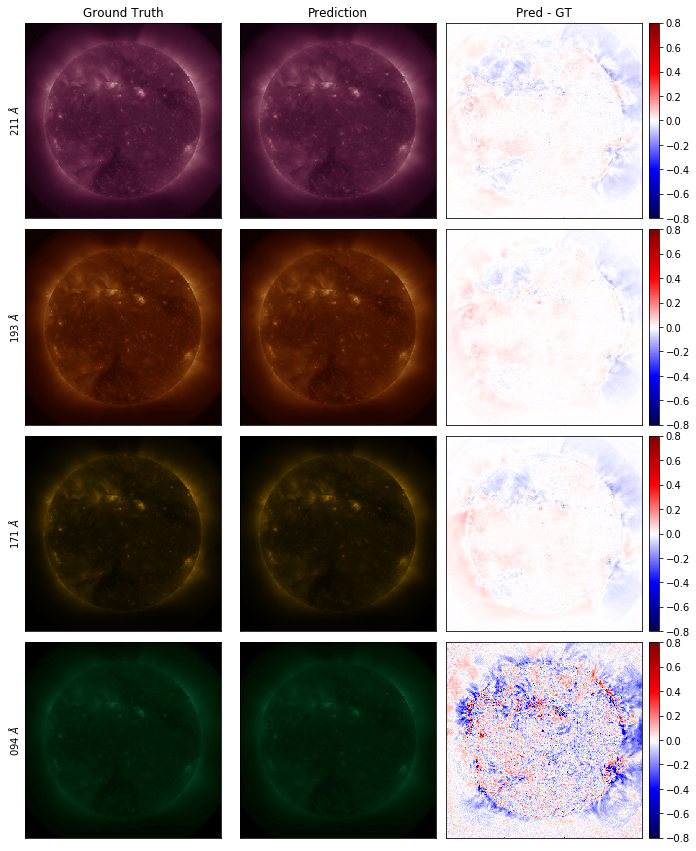

In [28]:
fig = plot_4ch_grid(root_results_dict, ch_dict_root)
filename = output_path + "real_vs_pred_quiet_root.png"
fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)

## Images on active Sun

In [12]:
active_day = '2011-02-15 02:00:00'

### Compute predictions

In [13]:
nr_results_dict_active = compute_predictions(active_day, ch_dict, "model_nr")

-----211------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----193------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----171------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----094------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [14]:
root_results_dict_active = compute_predictions(active_day, ch_dict_root, "model_root")

-----211------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----193------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----171------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


-----094------


/home/luiz0992/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


### Plot images

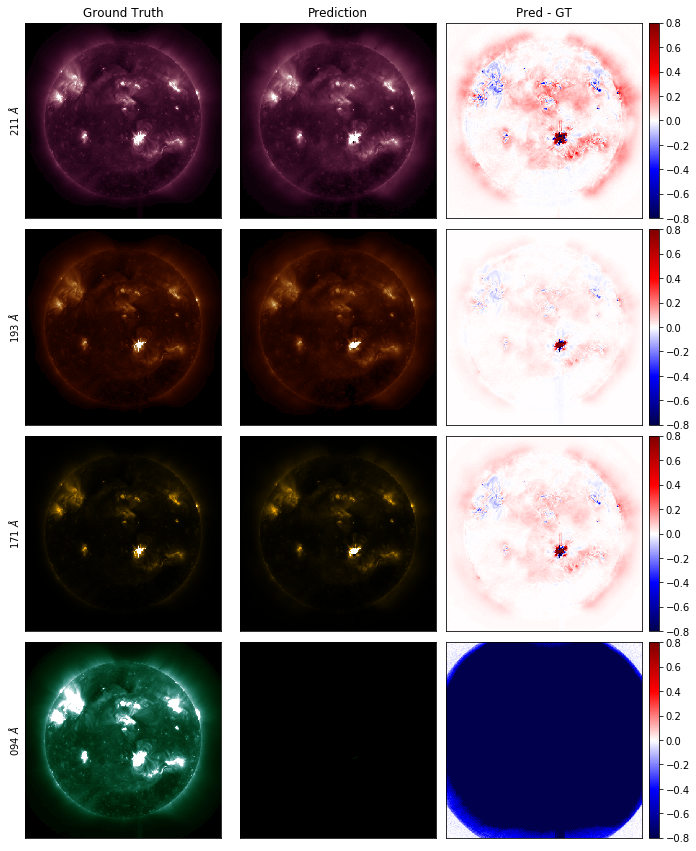

In [27]:
fig = plot_4ch_grid(nr_results_dict_active, ch_dict)
filename = output_path + "real_vs_pred_active_nr.png"
fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)


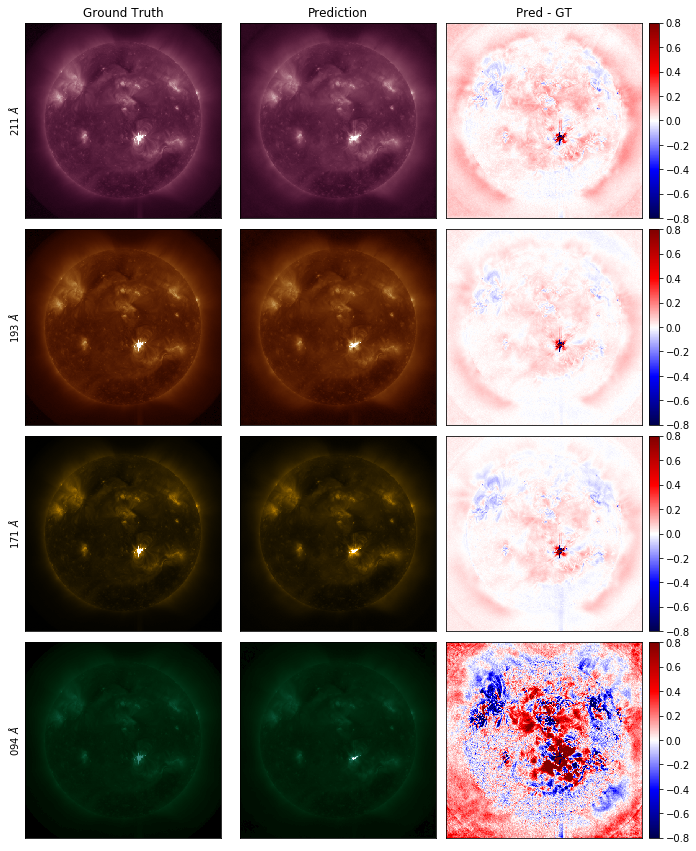

In [26]:
fig = plot_4ch_grid(root_results_dict_active, ch_dict_root)
filename = output_path + "real_vs_pred_active_root.png"
fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)